# Spaceship Titanic Lab

Данный notebook был первым проектом по ml.

Модели использованы не самые лучшие по качеству, но простые для начального понимания.

## Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

C:\Users\alibe\AppData\Local\Temp\ipykernel_4852\476165134.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_test = pd.read_csv('./test.csv')
df = pd.read_csv('./train.csv')

df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [137]:
df_res = pd.DataFrame()
df_res['PassengerId'] = df_test['PassengerId']

## Анализ данных

In [138]:
target = df['Transported']
unique, counts = np.unique(target, return_counts=True)
counts

array([4315, 4378], dtype=int64)

Число транспортированных и нетранспортированных примерно одинаковое

In [139]:
# Пропуски
df.isna().sum(axis=0)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

### Непрерывные фичи

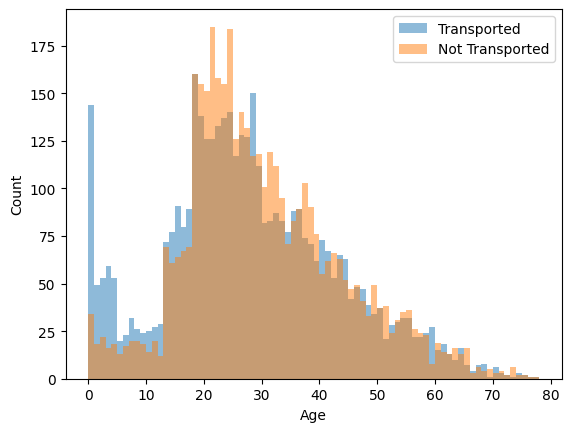

In [140]:
def hist_compare_cont(column, ceiling=False, r_wall=False, bins_ = 20):
    mask = df['Transported'] == True
    x_true = df[column][mask]
    x_false = df[column][~mask]
    if r_wall:
        bins_ = 500
    if len(np.unique(x_true)) < 100: # проверка для Age
        bins_ = np.unique(x_true)

    plt.hist(x_true, bins=bins_, label='Transported', alpha=0.5)
    plt.hist(x_false, bins=bins_, label='Not Transported', alpha=0.5)
    if ceiling:
        plt.ylim([0,100])
    if r_wall:
        plt.xlim([0, 2000])
    plt.legend()
    plt.xlabel(column)
    plt.ylabel('Count')

hist_compare_cont('Age')

- С 0 до 19 лет больше вероятность быть транспортированным
- С 20 до (примерно) 40 больше вероятность быть не транспортированным
- С 40+ примерно одинаково

Как будто есть смысл разбить их на группы, но экспериментально проверено, что модели умные и точнее получаются, если без изменений Age оставить

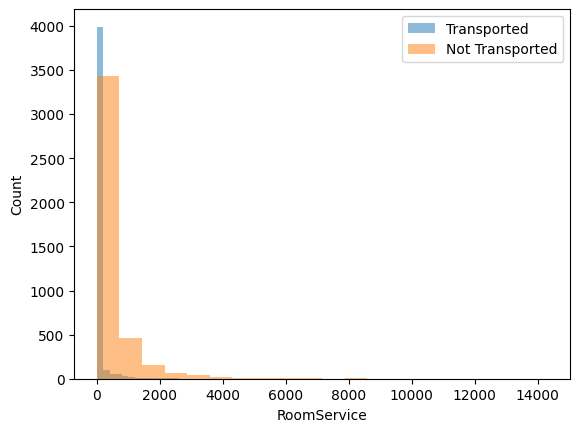

In [141]:
hist_compare_cont('RoomService')

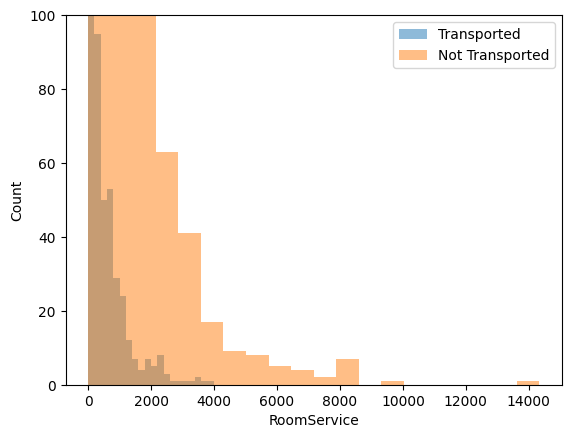

In [142]:
hist_compare_cont('RoomService', ceiling=True)

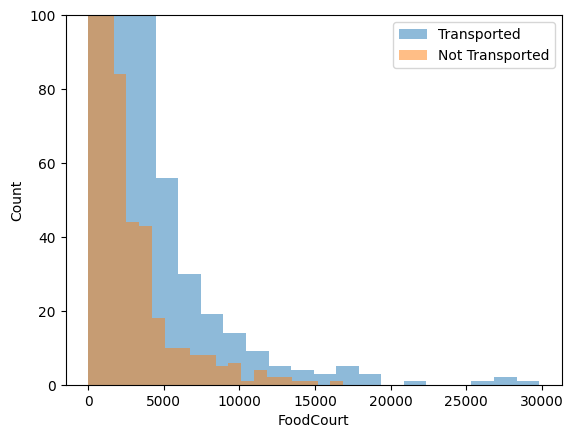

In [143]:
hist_compare_cont('FoodCourt', ceiling=True)

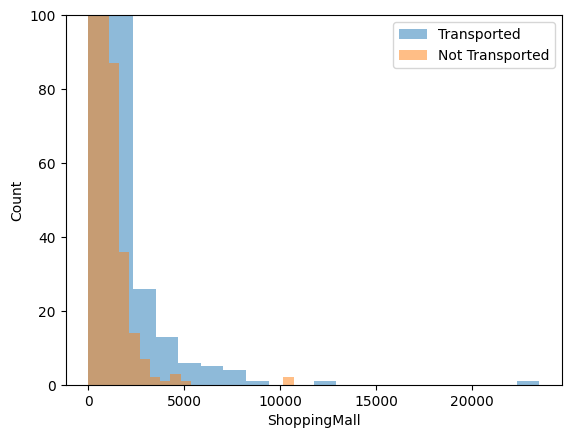

In [144]:
hist_compare_cont('ShoppingMall', ceiling=True)

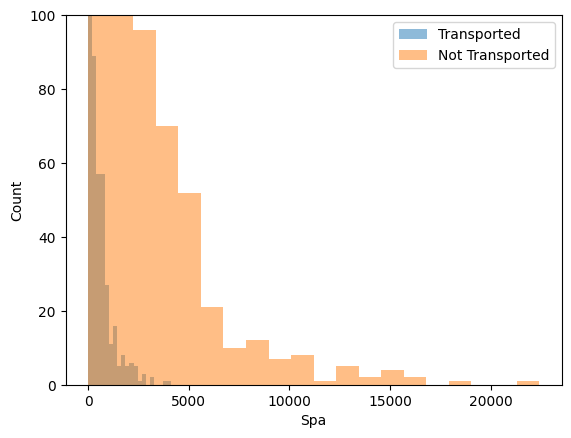

In [145]:
hist_compare_cont('Spa', ceiling=True)

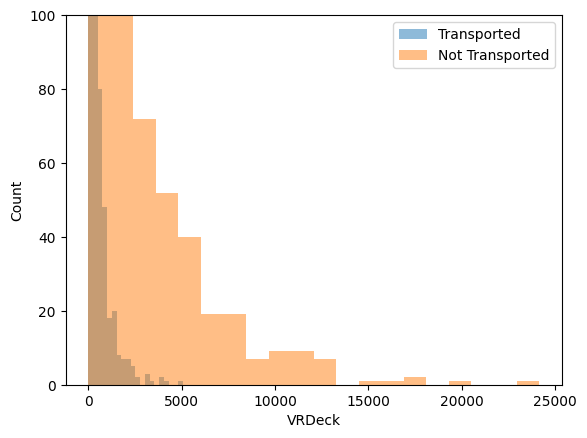

In [146]:
hist_compare_cont('VRDeck', ceiling=True)

- Много людей тратят мало денег
- Много людей не тратят вообще - они более вероятно будут транспортированны

Для тех, кто тратит деньги:
- Если они тратят на RoomService - более вероятно НЕ быть транспортированным
- Если они тратят на FoodCourt - более вероятно быть транспортированным
- Если они тратят на ShoppingMall - более вероятно быть транспортированным
- Если они тратят на Spa - более вероятно НЕ быть транспортированным
- Если они тратят на VRDeck - более вероятно НЕ быть транспортированным

Создадим фичи: сумма затрат и потратили ли вообще что-то в сумме

### Категориальные фичи

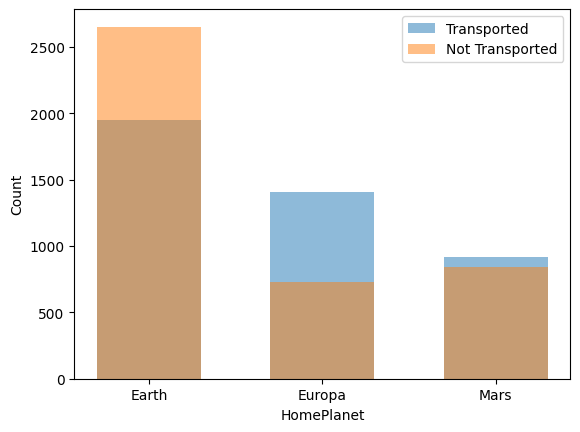

In [147]:
def hist_compare_cat(column):
    mask = df['Transported'] == True
    x_true = df[column][mask]
    x_false = df[column][~mask]
    x_names = list(set(df[column]))
    x_names = [a for a in x_names if pd.notnull(a)] # удаляем nan
    x_names = sorted(x_names) # сортирую по индексу. Делаю так, чтобы столбцы совпадали в counts
    counts_true = x_true.value_counts().sort_index()
    counts_false = x_false.value_counts().sort_index()
    plt.bar(x_names, counts_true, width=0.6, label='Transported', alpha=0.5)
    plt.bar(x_names, counts_false, width=0.6, label='Not Transported', alpha=0.5)
    plt.legend()
    plt.xlabel(column)
    plt.ylabel('Count')
hist_compare_cat('HomePlanet')

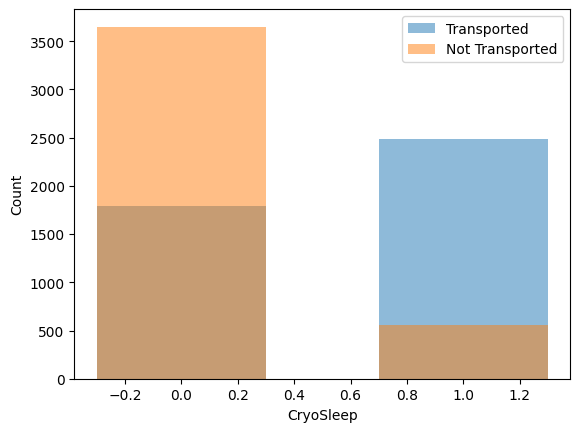

In [148]:
hist_compare_cat('CryoSleep')

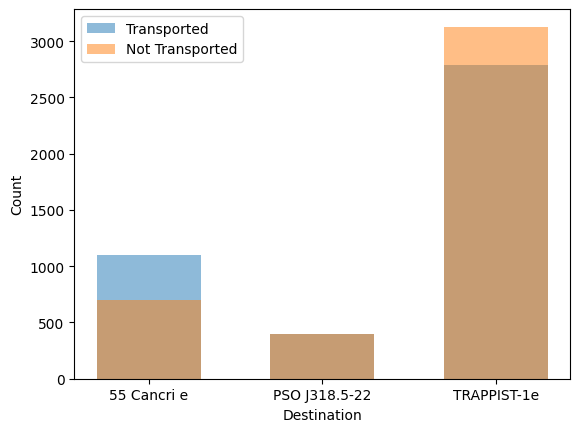

In [149]:
hist_compare_cat('Destination')

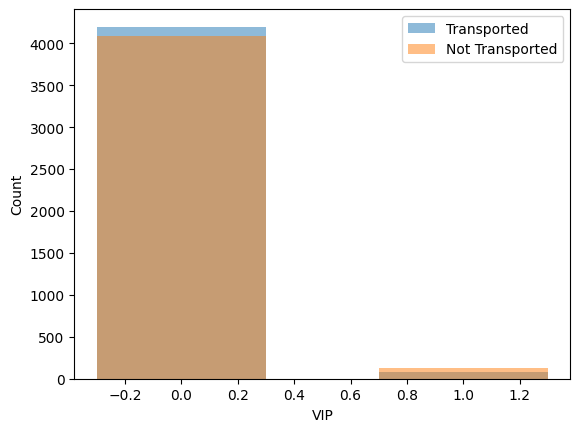

In [150]:
hist_compare_cat('VIP')

- VIP особо не несет информации
- CryoSleep очень полезная фича

С PassengerID пока ничего не делаем (не хватает времени)

## Feature Engeneering
Отрезки для разбиений на группы следующих признаков получены из анализа построений решающих деревьев - по одному на признак

В notebook'е был оставлен только Age как пример - разбивать на группы вышло менее точно, чем просто оставить признаки как есть

### Age

C:\Users\alibe\AppData\Local\Temp\ipykernel_3204\3638408696.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Age_group'][df['Age'] <= 4] = '0-4'
C:\Users\alibe\AppData\Local\Temp\ipykernel_3204\3638408696.py:2: SettingWithCopyWarning:

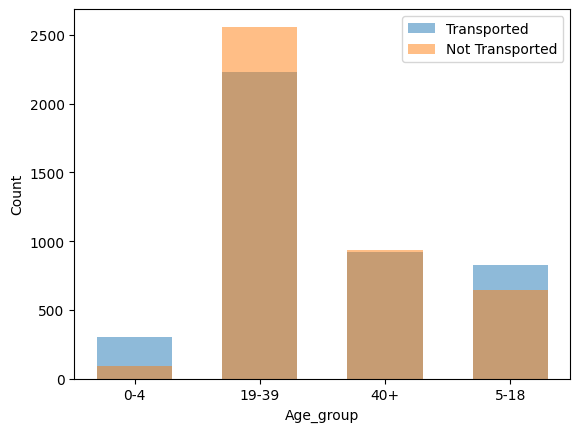

In [151]:
df['Age_group'] = np.nan
df['Age_group'][df['Age'] <= 4] = '0-4'
df['Age_group'][(df['Age'] >= 4) & (df['Age'] <= 18)] = '5-18'
df['Age_group'][(df['Age'] >= 19) & (df['Age'] <= 39)] = '19-39'
df['Age_group'][(df['Age'] >= 40)] = '40+'

df_test['Age_group'] = np.nan
df_test['Age_group'][df['Age'] <= 4] = '0-4'
df_test['Age_group'][(df['Age'] >= 4) & (df['Age'] <= 18)] = '5-18'
df_test['Age_group'][(df['Age'] >= 19) & (df['Age'] <= 39)] = '19-39'
df_test['Age_group'][(df['Age'] >= 40)] = '40+'

hist_compare_cat('Age_group')

### Spending

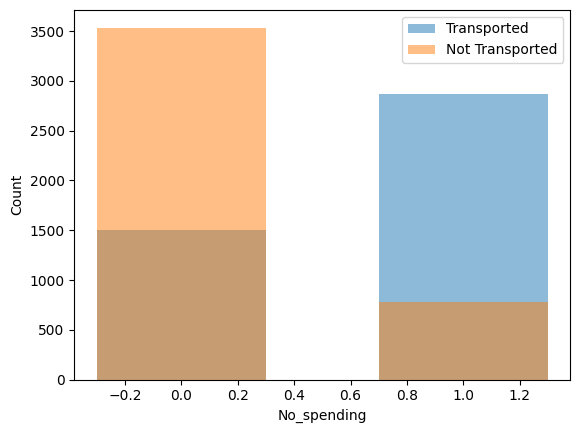

In [152]:
spend_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['Total_spending']=df[spend_feats].sum(axis=1)
df['No_spending']=(df['Total_spending']==0).astype(int)

df_test['Total_spending']=df_test[spend_feats].sum(axis=1)
df_test['No_spending']=(df_test['Total_spending']==0).astype(int)

hist_compare_cat('No_spending')

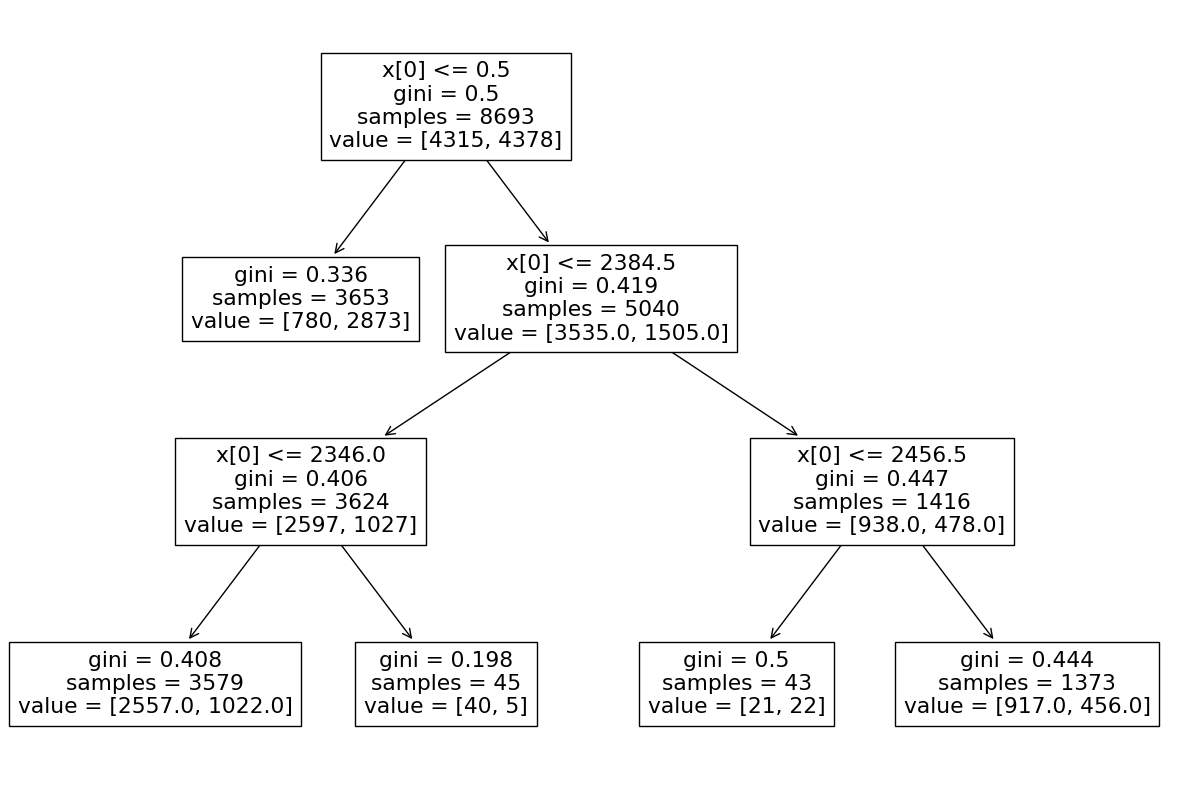

In [153]:
def build_tree(col):
    df_tree = pd.DataFrame()
    df_tree[col] = df[col]
    df_tree['Transported'] = df['Transported']
    cat_features = [col]

    
    target = 'Transported'

    X = df_tree.drop(columns=target).values
    y = df_tree[target].values

    model = DecisionTreeClassifier(max_depth=3)
    model.fit(X, y)
    pred = model.predict(X)
    plt.figure(figsize=(15,10))
    plot_tree(model)
build_tree('Total_spending')

### Кабина

In [154]:
def cabin_parse(df):
    df['Cabin'].fillna('np.nan/-1/np.nan',inplace=True)  # можем сплитить nan
    
    df['Cabin_deck'] = df['Cabin'].apply(lambda x: x.split("/")[0]).astype(str)
    df['Cabin_number']  = df['Cabin'].apply(lambda x: x.split("/")[1]).astype(float)
    df['Cabin_side'] = df['Cabin'].apply(lambda x: x.split("/")[2]).astype(str)

    df['Cabin_deck'] = df['Cabin_deck'].replace('np.nan', np.nan) # возвращаем nan обратно
    df['Cabin_number'] = df['Cabin_number'].replace(-1, np.nan)
    df['Cabin_side'] = df['Cabin_side'].replace('np.nan', np.nan)
    return df

In [155]:
df = cabin_parse(df)
df_test = cabin_parse(df_test)

C:\Users\alibe\AppData\Local\Temp\ipykernel_3204\258522693.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin'].fillna('np.nan/-1/np.nan',inplace=True)  # можем сплитить nan
C:\Users\alibe\AppData\Local\Temp\ipykernel_3204\258522693.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

### PassengerId

In [156]:
#df['Passenger_num'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
#print('Число пропусков: ' + str(df['Passenger_num'].isna().sum()))
#hist_compare_cont('Passenger_num', bins_ = 100)

## Заполняем пропуски и удаляем фичи, с которыми не будем работать
- В категориальных фичах заменяем пропуски на моду
- Для непрерывных фич сделали новые категориальные, старые - дропнем

In [157]:
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'No_spending', 'Cabin_deck', 'Cabin_side']
cont_features = ['Age', 'Total_spending', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_number']
drop_features = ['PassengerId', 'Age_group', 'Name', 'Cabin']

def fillna_drop(df):
    for f in cat_features:
        df[f] = df[f].fillna(df[f].mode().iloc[0])  
    for f in cont_features:
        df[f] = df[f].fillna(df[f].median())    
    df = df.drop(columns=drop_features)
    return df

df = fillna_drop(df)
df_test = fillna_drop(df_test)
df

C:\Users\alibe\AppData\Local\Temp\ipykernel_3204\218252312.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[f] = df[f].fillna(df[f].mode().iloc[0])
C:\Users\alibe\AppData\Local\Temp\ipykernel_3204\218252312.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[f] = df[f].fillna(df[f].mode().iloc[0])


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_spending,No_spending,Cabin_deck,Cabin_number,Cabin_side
0,Europa,False,TRAPPIST-1e,39.0000,False,0.0000,0.0000,0.0000,0.0000,0.0000,False,0.0000,1,B,0.0000,P
1,Earth,False,TRAPPIST-1e,24.0000,False,109.0000,9.0000,25.0000,549.0000,44.0000,True,736.0000,0,F,0.0000,S
2,Europa,False,TRAPPIST-1e,58.0000,True,43.0000,"3,576.0000",0.0000,"6,715.0000",49.0000,False,"10,383.0000",0,A,0.0000,S
3,Europa,False,TRAPPIST-1e,33.0000,False,0.0000,"1,283.0000",371.0000,"3,329.0000",193.0000,False,"5,176.0000",0,A,0.0000,S
4,Earth,False,TRAPPIST-1e,16.0000,False,303.0000,70.0000,151.0000,565.0000,2.0000,True,"1,091.0000",0,F,1.0000,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0000,True,0.0000,"6,819.0000",0.0000,"1,643.0000",74.0000,False,"8,536.0000",0,A,98.0000,P
8689,Earth,True,PSO J318.5-22,18.0000,False,0.0000,0.0000,0.0000,0.0000,0.0000,False,0.0000,1,G,"1,499.0000",S
8690,Earth,False,TRAPPIST-1e,26.0000,False,0.0000,0.0000,"1,872.0000",1.0000,0.0000,True,"1,873.0000",0,G,"1,500.0000",S
8691,Europa,False,55 Cancri e,32.0000,False,0.0000,"1,049.0000",0.0000,353.0000,"3,235.0000",False,"4,637.0000",0,E,608.0000,S


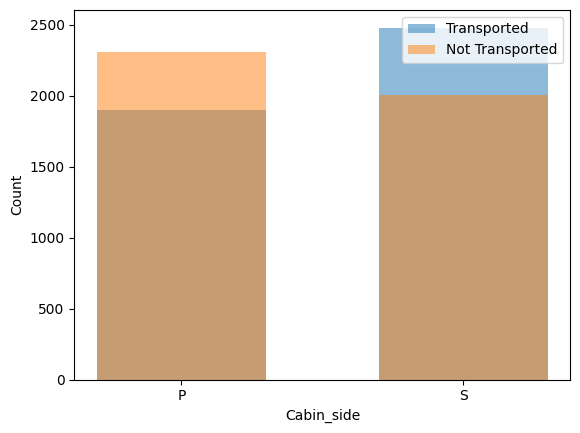

In [158]:
hist_compare_cat('Cabin_side')

## Кодирование

In [159]:
bin_feats = ['CryoSleep', 'No_spending', 'VIP', 'Cabin_side'] #TODO переписать на функцию
cat_feats = ['HomePlanet', 'Destination', 'Cabin_deck']

def encode(df):
    for f in bin_feats:
        map_dict = {value: i for i, value in enumerate(set(df[f]))}
        df[f] = df[f].map(map_dict)
    
    # One Hot Encoding
    for f in cat_feats:
        values = set(df[f])
        for v in values:
            df[f + '_' + v] = df[f] == v            
        df = df.drop(columns=f)
    return df
df = encode(df)
df_test = encode(df_test)

In [160]:
pd.set_option('display.max_columns', None)
df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_spending,No_spending,Cabin_number,Cabin_side,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Earth,Destination_55 Cancri e,Destination_TRAPPIST-1e,Destination_PSO J318.5-22,Cabin_deck_T,Cabin_deck_E,Cabin_deck_A,Cabin_deck_B,Cabin_deck_F,Cabin_deck_G,Cabin_deck_D,Cabin_deck_C
0,0,39.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,False,0.0000,1,0.0000,0,True,False,False,False,True,False,False,False,False,True,False,False,False,False
1,0,24.0000,0,109.0000,9.0000,25.0000,549.0000,44.0000,True,736.0000,0,0.0000,1,False,False,True,False,True,False,False,False,False,False,True,False,False,False
2,0,58.0000,1,43.0000,"3,576.0000",0.0000,"6,715.0000",49.0000,False,"10,383.0000",0,0.0000,1,True,False,False,False,True,False,False,False,True,False,False,False,False,False
3,0,33.0000,0,0.0000,"1,283.0000",371.0000,"3,329.0000",193.0000,False,"5,176.0000",0,0.0000,1,True,False,False,False,True,False,False,False,True,False,False,False,False,False
4,0,16.0000,0,303.0000,70.0000,151.0000,565.0000,2.0000,True,"1,091.0000",0,1.0000,1,False,False,True,False,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0000,1,0.0000,"6,819.0000",0.0000,"1,643.0000",74.0000,False,"8,536.0000",0,98.0000,0,True,False,False,True,False,False,False,False,True,False,False,False,False,False
8689,1,18.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,False,0.0000,1,"1,499.0000",1,False,False,True,False,False,True,False,False,False,False,False,True,False,False
8690,0,26.0000,0,0.0000,0.0000,"1,872.0000",1.0000,0.0000,True,"1,873.0000",0,"1,500.0000",1,False,False,True,False,True,False,False,False,False,False,False,True,False,False
8691,0,32.0000,0,0.0000,"1,049.0000",0.0000,353.0000,"3,235.0000",False,"4,637.0000",0,608.0000,1,True,False,False,True,False,False,False,True,False,False,False,False,False,False


Уберем столбцы, которые имеют низкий вес после построения модели - это дает маленький прирост в точности

In [161]:
low_weight_features = ['Cabin_deck_D', 'Cabin_deck_T', 'Cabin_deck_B', 'Destination_PSO J318.5-22']
df = df.drop(columns=low_weight_features)
df_test = df_test.drop(columns=low_weight_features)

## Моделирование

In [162]:
target = 'Transported'

X = df.drop(columns=target).values
y = df[target].values

### Дерево

In [163]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
pred = model.predict(X)

In [164]:
np.mean((y == pred))

0.7584263200276085

[Text(0.5, 0.875, 'x[8] <= 0.5\ngini = 0.5\nsamples = 8693\nvalue = [4315, 4378]'),
 Text(0.25, 0.625, 'x[14] <= 0.5\ngini = 0.336\nsamples = 3653\nvalue = [780, 2873]'),
 Text(0.125, 0.375, 'x[17] <= 0.5\ngini = 0.129\nsamples = 1834\nvalue = [127, 1707]'),
 Text(0.0625, 0.125, 'gini = 0.044\nsamples = 1632\nvalue = [37, 1595]'),
 Text(0.1875, 0.125, 'gini = 0.494\nsamples = 202\nvalue = [90.0, 112.0]'),
 Text(0.375, 0.375, 'x[10] <= 532.5\ngini = 0.46\nsamples = 1819\nvalue = [653, 1166]'),
 Text(0.3125, 0.125, 'gini = 0.492\nsamples = 705\nvalue = [309, 396]'),
 Text(0.4375, 0.125, 'gini = 0.427\nsamples = 1114\nvalue = [344, 770]'),
 Text(0.75, 0.625, 'x[4] <= 668.5\ngini = 0.419\nsamples = 5040\nvalue = [3535.0, 1505.0]'),
 Text(0.625, 0.375, 'x[5] <= 541.0\ngini = 0.358\nsamples = 3827\nvalue = [2935, 892]'),
 Text(0.5625, 0.125, 'gini = 0.268\nsamples = 2961\nvalue = [2490, 471]'),
 Text(0.6875, 0.125, 'gini = 0.5\nsamples = 866\nvalue = [445, 421]'),
 Text(0.875, 0.375, 'x[6] <

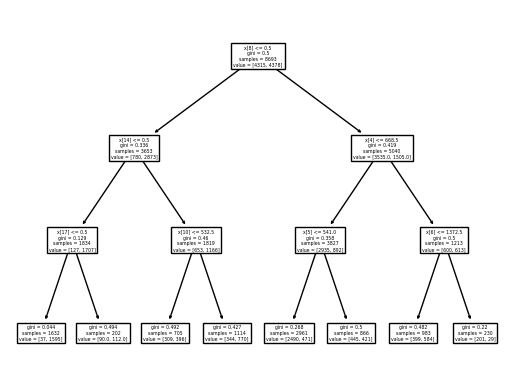

In [165]:
plot_tree(model)

In [166]:
def kfold(X, y, k=5):
    pre_mask = np.arange(y.size) % k
    
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []
    
    for i in range(k):
        val_mask = pre_mask == i
        train_mask = ~val_mask
        
        y_vals.append(y[val_mask])
        y_trains.append(y[~val_mask])
        X_vals.append(X[val_mask])
        X_trains.append(X[~val_mask])
    result = []
    for i in range(k):
        result.append(((X_trains[i], y_trains[i]), (X_vals[i], y_vals[i])))
    return result


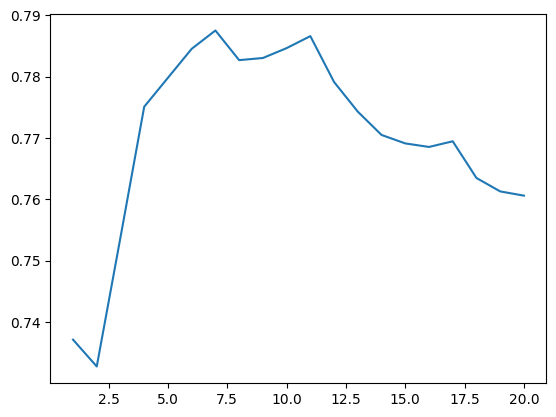

In [167]:
acc_means = []
depths = []
for d in range(1, 21):
    model = DecisionTreeClassifier(max_depth=d)
    accs = []
    for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 10):
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        accs.append(np.mean(pred == y_val))
    acc_mean = np.mean(accs)
    acc_means.append(acc_mean)
    depths.append(d)

plt.plot(depths, acc_means)

### Ансамбли
Стандартные гиперпараметры

In [168]:
model = GradientBoostingClassifier()
#model = RandomForestClassifier()
accs = []
for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 10):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    accs.append(np.mean(pred == y_val))
acc_mean = np.mean(accs)
acc_mean


0.8059344205917756

### Вес признаков в модели

Стоит отметить, что в документации написано, что при использовании .feature_importances_ фичи с высокой кардинальностью могут получать слишком много веса. Но по анализу графиков можно согласиться, что фичи, связанные с затратами, довольно информативны.

In [169]:
imp_features = model.feature_importances_
features = df.drop(columns='Transported').columns
df_imp_features = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":imp_features}))
pd.options.display.float_format = '{:,.4f}'.format
df_imp_features.sort_values(by=['weights'], ascending=False)

,features,weights
9,No_spending,0.2518
8,Total_spending,0.0968
0,CryoSleep,0.0905
4,FoodCourt,0.0871
6,Spa,0.0740
7,VRDeck,0.0724
5,ShoppingMall,0.0666
10,Cabin_number,0.0558
14,HomePlanet_Earth,0.0503
3,RoomService,0.0503


### Исследование гиперпараметров

#### learning_rate
Уменьшает вклад деревьев (default=0.1)

In [196]:
# learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

# def test_parametr(name, values):
#     accs_train_mean = []
#     accs_val_mean = []
#     for v in values:
#         accs_train = []
#         accs_val = []
#         for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 4):
#             model = eval('GradientBoostingClassifier({arg} = {value})'.format(arg = name, value = v))
#             model.fit(X_train, y_train)
#             pred_train = model.predict(X_train)
#             pred_val = model.predict(X_val)
#             accs_train.append(np.mean(pred_train == y_train))
#             accs_val.append(np.mean(pred_val == y_val))
#         accs_train_mean.append(np.mean(accs_train))
#         accs_val_mean.append(np.mean(accs_val))
#     plt.plot(values, accs_train_mean, 'b', label='Train')
#     plt.plot(values, accs_val_mean, 'r', label='Validation')
#     plt.legend()
#     plt.ylabel('Accuracy')
#     plt.xlabel(name)
#     print(values[np.array(accs_val_mean).argmax()], ': max accuracy ', max(accs_val_mean))
# test_parametr('learning_rate', learning_rates)

#### n_estimators
Число деревьев в ансамбле (default=100)

100 : max accuracy  0.8066243065877917


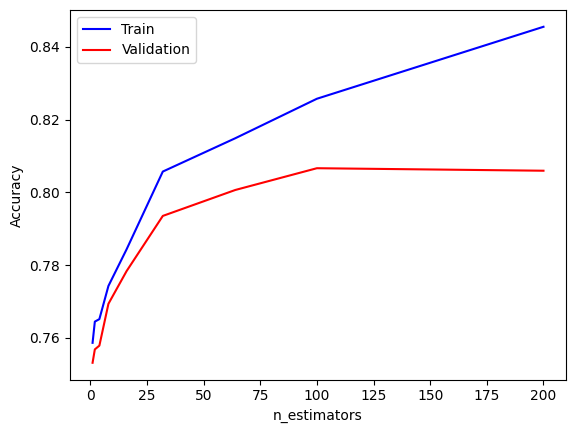

In [197]:
# n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
# test_parametr('n_estimators', n_estimators)

#### max_depth
Глубина деревьев (default=3)

5 : max accuracy  0.8109963544394256


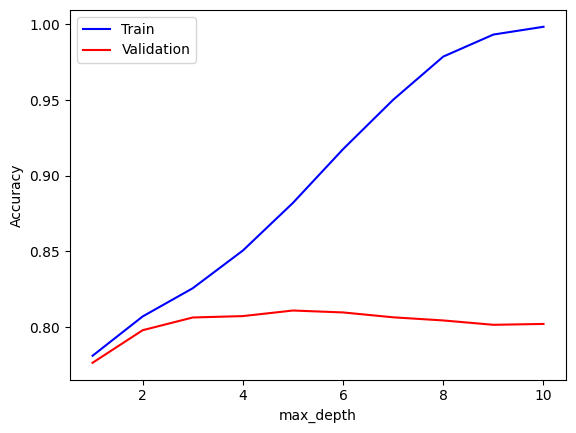

In [198]:
# max_depths = [x for x in range(1, 10)]

# test_parametr('max_depth', max_depths)

#### min_samples_split

The minimum number of samples required to split an internal node (default=2)

10 : max accuracy  0.8075446402300375


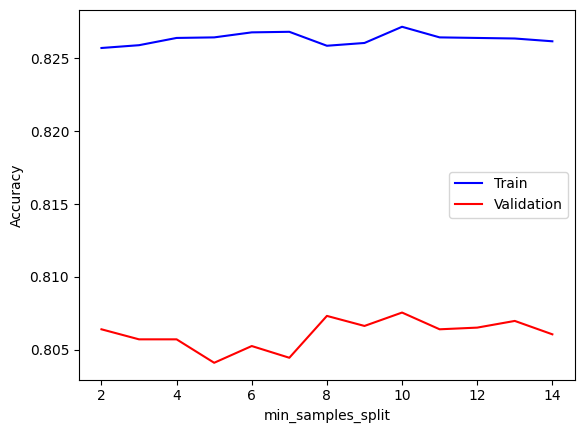

In [200]:
# min_samples_splits = [x for x in range(2, 15)]

# test_parametr('min_samples_split', min_samples_splits)

#### min_samples_leaf

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. (default=1)

2 : max accuracy  0.8066240949073495


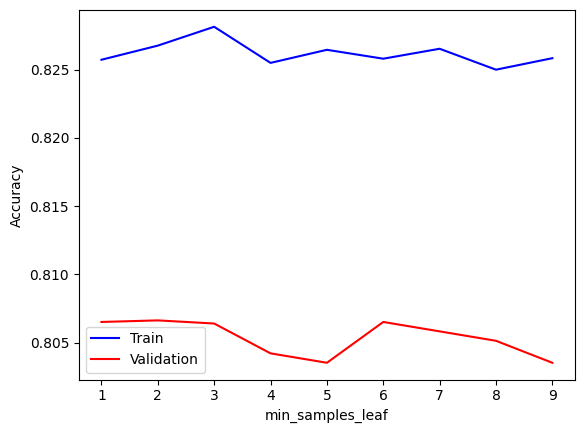

In [203]:
# min_samples_leafs = [x for x in range(1,10)]

# test_parametr('min_samples_leaf', min_samples_leafs)

#### max_features

The number of features to consider when looking for the best split (defaul='все')

23 : max accuracy  0.8065092582674972


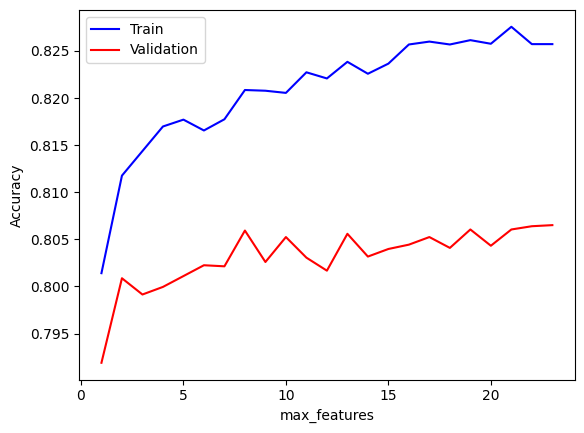

In [208]:
# max_features = [x for x in range(1, df.shape[1] + 1)]

# test_parametr('max_features', max_features)

### Лучшая модель

In [217]:
model = GradientBoostingClassifier(
    #learning_rate=0.25,
    max_depth=5,
    #min_samples_split=10,
)
accs = []
for ((X_train, y_train), (X_val, y_val)) in kfold(X, y, 10):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    accs.append(np.mean(pred == y_val))
acc_mean = np.mean(accs)
acc_mean

0.8113410843485047

## Подготовка submission для Kaggle

In [218]:
X = df.drop(columns=target).values
y = df[target].values
model = GradientBoostingClassifier(max_depth=5)
model.fit(X, y)
X_test = df_test.values
pred = model.predict(X_test)
pred

array([ True, False,  True, ...,  True,  True,  True])

In [219]:
df_res['Transported'] = pred
df_res

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [220]:
df_res.to_csv('res.csv', index=False)